# Debugging and Improving ML Models

Based on [Andrew Ng's Advice for applying Machine Learning](http://cs229.stanford.edu/materials/ML-advice.pdf)

# Quiz

What would you do to improve this model's performance?

<img src="img/ng-high-bias.png" width=600>
<div style="text-align: right">Source: A. Ng. "Advice for applying Machine Learning"</div>

 1. Choose a model class with higher complexity
 1. Get more data
 1. Remove features
 1. Create new features
 1. Choose a model class with less complexity

# More on Bias vs Variance

Typical learning curve for high variance


<img src="img/ng-high-variance.png" width=600>
<div style="text-align: right">Source: A. Ng. "Advice for applying Machine Learning"</div>

  * Test error still decreasing as m increases. Model has enough capacity, suggests larger training set will help.
  * Large gap between training and test error. 

Scikit-learn provides a [Learning Curves](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve)
```python
from sklearn.model_selection import learning_curve
```

# More on Bias vs Variance

Typical learning curve for high bias


<img src="img/ng-high-bias.png" width=600>
<div style="text-align: right">Source: A. Ng. "Advice for applying Machine Learning"</div>

  * Even training error is unacceptably high; more data wont help.
    - Create new features
    - Buy a newer GPU to train deeper neural nets
  * Small gap between training and test error. 

Populating the interactive namespace from numpy and matplotlib


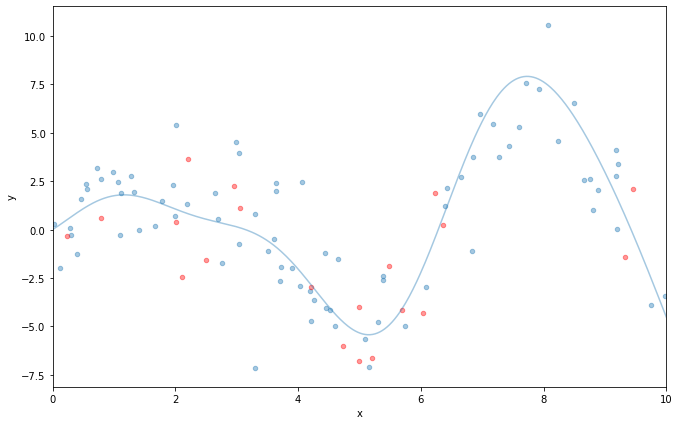

In [1]:
%pylab inline
import numpy as np
from sklearn.model_selection import train_test_split

FIGSIZE = (11, 7)

def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    np.random.seed(15)
    X = np.random.uniform(0, 10, size=n_samples)[:, np.newaxis]
    y = ground_truth(X.ravel()) + np.random.normal(scale=2, size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_data(100)

# plot ground truth
x_plot = np.linspace(0, 10, 500)

def plot_data(alpha=0.4, s=20):
    fig = plt.figure(figsize=FIGSIZE)
    gt = plt.plot(x_plot, ground_truth(x_plot), alpha=alpha, label='ground truth')

    # plot training and testing data
    plt.scatter(X_train, y_train, s=s, alpha=alpha)
    plt.scatter(X_test, y_test, s=s, alpha=alpha, color='red')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('x')
    
annotation_kw = {'xycoords': 'data', 'textcoords': 'data',
                 'arrowprops': {'arrowstyle': '->', 'connectionstyle': 'arc'}}
    
plot_data()

# Regression Tree

  * `max_depth` argument controlls the depth of the tree
  * The deeper the tree the more variance can be explained

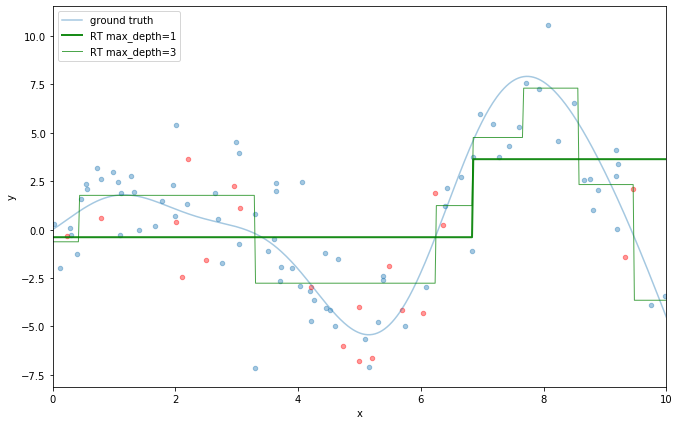

In [2]:
from sklearn.tree import DecisionTreeRegressor
plot_data()
est = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=1', color='g', alpha=0.9, linewidth=2)

est = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=3', color='g', alpha=0.7, linewidth=1)

plt.legend(loc='upper left')

# Function approximation with Gradient Boosting

  * `n_estimators` argument controls the number of trees
  * `staged_predict` method allows us to step through predictions as we add more trees

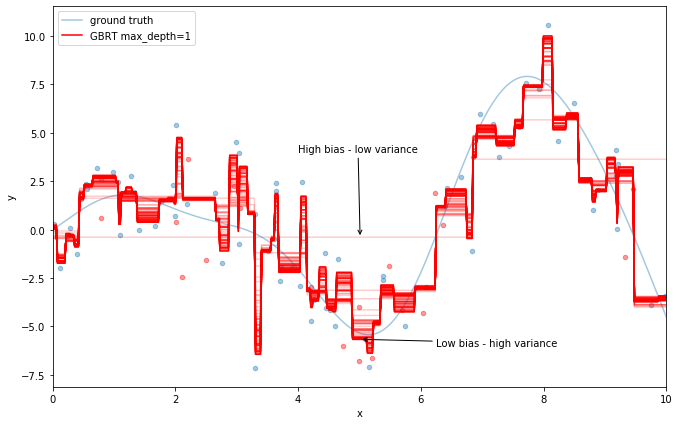

In [3]:
from itertools import islice
from sklearn.ensemble import GradientBoostingRegressor

plot_data()
est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

ax = plt.gca()
first = True

# step through prediction as we add 10 more trees.
for pred in islice(est.staged_predict(x_plot[:, np.newaxis]), 0, est.n_estimators, 10):
    plt.plot(x_plot, pred, color='r', alpha=0.2)
    if first:
        ax.annotate('High bias - low variance', xy=(x_plot[x_plot.shape[0] // 2],
                                                    pred[x_plot.shape[0] // 2]),
                                                    xytext=(4, 4), **annotation_kw)
        first = False

pred = est.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color='r', label='GBRT max_depth=1')
ax.annotate('Low bias - high variance', xy=(x_plot[x_plot.shape[0] // 2],
                                            pred[x_plot.shape[0] // 2]),
                                            xytext=(6.25, -6), **annotation_kw)
plt.legend(loc='upper left')

# Model complexity
  * The number of trees and the depth of the individual trees control model complexity

# Deviance plot
  * Diagnostic to determine if model is overfitting
  * Plots the training/testing error (deviance) as a function of the number of trees (=model complexity)

Text(810, 3.5, 'train-test gap')

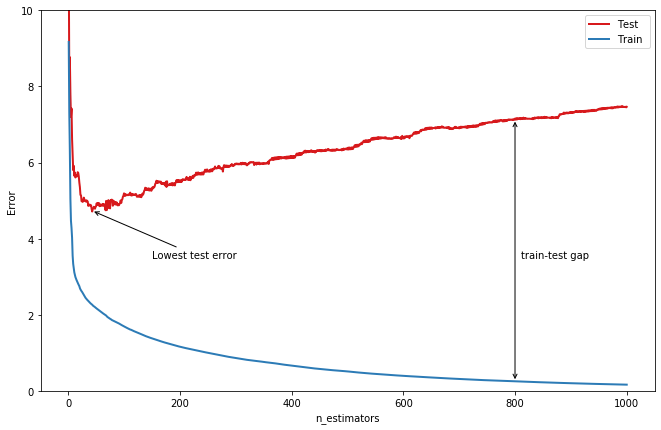

In [4]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=FIGSIZE)
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc='upper right')

# add some annotations
ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02),
            xytext=(150, 3.5), **annotation_kw)

ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
                  xytext=(800, est.train_score_[799]), textcoords='data',
                  arrowprops={'arrowstyle': '<->'})
ax.text(810, 3.5, 'train-test gap')

# Overfitting

  * Large gap means **overfitting** we have to **regularize**!
  
### GBM Regularization

  * Tree depth `max_depth` (variance++)
  * Shrinkage `learning_rate` (variance--)
  * Randomization (`subsample`, `max_features`) (variance--)
  
Lets try shallower trees (`min_samples_leaf=3` instead of 1):

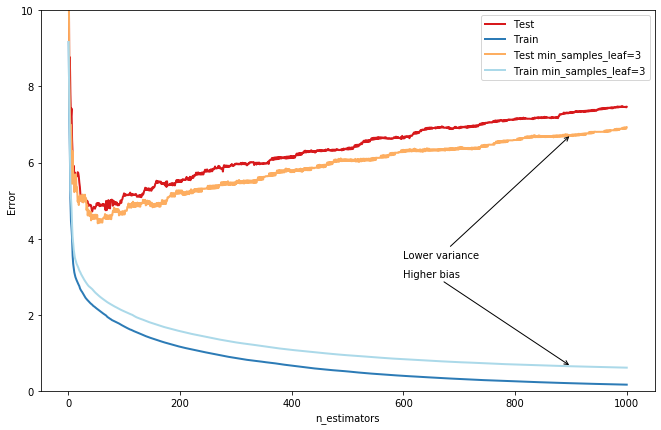

In [5]:
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.items())

fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'min_samples_leaf': 3}, ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, 
                                    learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Higher bias', xy=(900, est.train_score_[899]), xytext=(600, 3), **annotation_kw)
ax.annotate('Lower variance', xy=(900, test_dev[899]), xytext=(600, 3.5), **annotation_kw)
plt.legend(loc='upper right')